<a href="https://colab.research.google.com/github/VictorHNascimento/Analise-Classificacao-de-Cancer-de-Mama/blob/main/Projeto_CancerMama_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
!pip install Optuna

#Importando Dataset

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [118]:
#Importando Dataset
url = 'https://raw.githubusercontent.com/VictorHNascimento/Analise-Classificacao-de-Cancer-de-Mama/main/breast_cancer_ajustado.csv'
!wget {url} -O breastcancer.csv
df = pd.read_csv('breastcancer.csv')
df.head()

--2024-06-05 21:10:07--  https://raw.githubusercontent.com/VictorHNascimento/Analise-Classificacao-de-Cancer-de-Mama/main/breast_cancer_ajustado.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125575 (123K) [text/plain]
Saving to: ‘breastcancer.csv’

breastcancer.csv    100%[===================>] 122.63K  --.-KB/s    in 0.02s   

2024-06-05 21:10:08 (6.02 MB/s) - ‘breastcancer.csv’ saved [125575/125575]



,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


#Verificando Outliers

In [119]:
#Função Para Detectar Outliers
def detecta_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

# Função Para Contar Outliers Por Linha
def conta_outliers_linha(df):
    #Criando um novo DF
    outliers_df = pd.DataFrame()

    # Detecta os Outliers Em Cada Coluna
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:  # Verificar se a coluna é numérica
            outliers_df[column] = detecta_outliers(df[column])

    # Soma os Outliers de Cada Coluna por Linha
    df['outliers_count'] = outliers_df.sum(axis=1)

    return df

In [120]:
#Aplicando a Validaçãodos Outliers
df = conta_outliers_linha(df)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis,outliers_count
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,8
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,2
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1,12
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,2


In [121]:
#Filtra Pela Quantidade de Outliers
df_sorted = df.sort_values(by='outliers_count', ascending=False)

# Calcular o número de registros correspondente aos 5% com mais outliers
num_top_outliers = int(0.05 * len(df_sorted))  # 5% dos registros

# Selecionar os top 5% com mais outliers
top_outliers = df_sorted.head(num_top_outliers)

# Remover os registros selecionados do DataFrame original
df = df.drop(top_outliers.index)
df = df.drop(['outliers_count'], axis=1)

In [122]:
#Verificando Contagem de Categorias e Total
contagem = df['diagnosis'].value_counts()
print(f'Valores de cada categoria:\n{contagem}')

print('Total de Dados:', len(df))

Valores de cada categoria:
diagnosis
0    354
1    187
Name: count, dtype: int64
Total de Dados: 541


#Escolhendo os Melhores Parametros e Treinando Modelo

In [123]:
#Separando em treino e teste
x = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [124]:
import optuna
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def objetivo(trial, x, y):
    # Definir os hiperparâmetros a serem testados
    param_grid = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 500),
      'max_depth': trial.suggest_int('max_depth', 10, 50),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }

    # Treinar e avaliar o modelo usando validação cruzada
    classifier = RandomForestClassifier(**param_grid)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

#Função Para Definir Os Melhores Hiperparametros
def defineHiperparametros(x, y):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objetivo(trial, x, y), n_trials=100)

    print("Melhores hiperparâmetros:")
    print(study.best_params)
    print("Melhor pontuação de acurácia:", study.best_value)

    return study.best_params

params = {'n_estimators': 446, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1} #Hiperparametros Selecionados Pela Função

In [125]:
#Treinando o Modelo
def treinaModelo(x_train, y_train, params):
  classifier = RandomForestClassifier(**params)
  modelo = classifier.fit(x_train, y_train)
  return modelo

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = treinaModelo(x_train, y_train, params)

#Avaliando o Modelo

In [126]:
from sklearn.metrics import accuracy_score, classification_report

In [127]:
#Predizendo os resultados
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

In [128]:
#Vendo o Classification Report
print("Classification Report do Treino:\n", classification_report(y_train, pred_train))
print()
print("Classification Report do Teste:\n", classification_report(y_test, pred_test))

Classification Report do Treino:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       155

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432


Classification Report do Teste:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        77
           1       1.00      0.94      0.97        32

    accuracy                           0.98       109
   macro avg       0.99      0.97      0.98       109
weighted avg       0.98      0.98      0.98       109



In [129]:
#Verificando Overfiting
accuracy_train = accuracy_score(y_train, pred_train)
print(f"Acurácia (Treinamento) com as previsões já realizadas: {accuracy_train*100:.2f}")

accuracy_test = accuracy_score(y_test, pred_test)
print(f'Acurácia (Teste) com as previsões já realizadas: {accuracy_test*100:.2f}')

percentage_difference= (accuracy_train-accuracy_test) * 100
print(f'Diferença Percentual: {percentage_difference:.2f}%')

Acurácia (Treinamento) com as previsões já realizadas: 100.00
Acurácia (Teste) com as previsões já realizadas: 98.17
Diferença Percentual: 1.83%


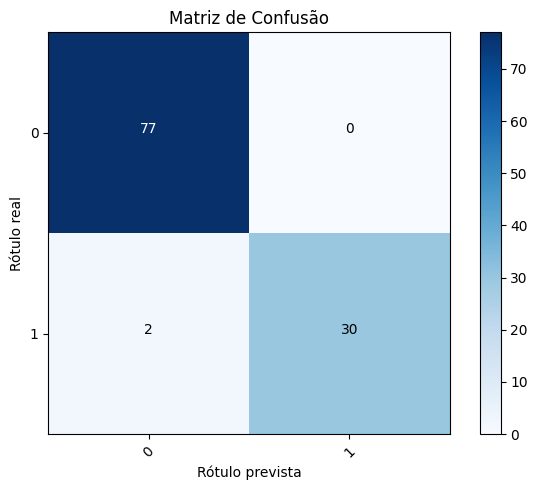

In [130]:
#Plot da Matriz de Confusão
def plotMatriz(classificador, y, y_pred, cmap = plt.cm.Blues, normalize = False):
  from sklearn.metrics import confusion_matrix
  import itertools
  cm = confusion_matrix(y, y_pred)
  classes = classificador.classes_
  title = 'Matriz de Confusão'

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('Rótulo real')
  plt.xlabel('Rótulo prevista')

plotMatriz(model, y_test, pred_test)

In [131]:
#Salvando o Modelo
import joblib
joblib.dump(model, 'cancer_mama_classifier.pkl')

['cancer_mama_classifier.pkl']